***
# <span style='color:Blue'>Classification of orthopedic patients based on biomechanical features</span>

***

#### <span style='color:Blue'>Import the required packages</span>

In [1]:
import pandas as pd              # Perform operations on data frames
import numpy as np               # Perform numeric operations on data
import matplotlib.pyplot as plt  # For static visualizations
import seaborn as sns            # For advanced visualizations
import math
import scipy.stats as stats      # To perform statistical operations
#from sklearn.model_selection import GridSearchCV  # To perform grid search for optimal parameters
#Loading all the necessary supervised learning related modules 
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import zscore
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import average_precision_score, confusion_matrix, accuracy_score, classification_report, plot_confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.svm import SVC
# To support the backend renedering of figures
%matplotlib inline

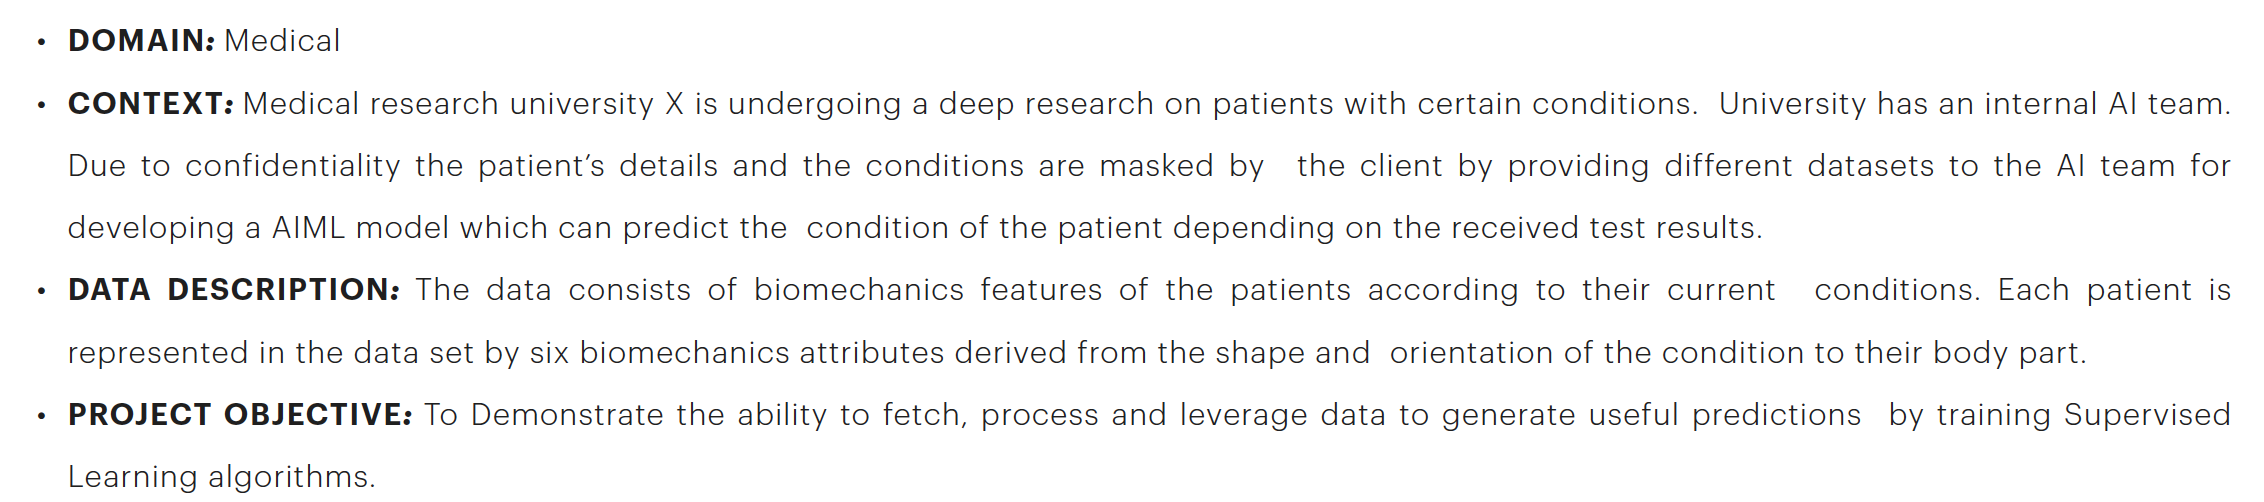

## Dataset Details

- The task consists in classifying patients as belonging to one out of three categories: Normal (100 patients), Disk Hernia (60 patients) or Spondylolisthesis (150 patients).

- Each patient is represented in the data set by six biomechanical attributes derived from the shape and orientation of the pelvis and lumbar spine (each one is a column):
    - pelvic incidence
    - pelvic tilt
    - lumbar lordosis angle
    - sacral slope
    - pelvic radius
    - grade of spondylolisthesis
- Acknowledgements: The original dataset was downloaded from UCI ML repository: Lichman, M. (2013). UCI Machine Learning  - Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science

## Understand the data

#### Read all the 3 CSV files

In [2]:
normal = pd.read_csv("Normal.csv")
htype = pd.read_csv ("Type_H.csv")
stype = pd.read_csv("Type_S.csv")

**Shape of all the dataframes**

In [3]:
print("Normal:",normal.shape)
print("Type_H:",htype.shape)
print("Type_s:",stype.shape)

Normal: (100, 7)
Type_H: (60, 7)
Type_s: (150, 7)


**Columns of all the dataframes**

In [4]:
print("Normal:\n",normal.columns)
print("\nType_H:\n",htype.columns)
print("\nType_s:\n",stype.columns)

Normal:
 Index(['P_incidence', 'P_tilt', 'L_angle', 'S_slope', 'P_radius', 'S_Degree',
       'Class'],
      dtype='object')

Type_H:
 Index(['P_incidence', 'P_tilt', 'L_angle', 'S_slope', 'P_radius', 'S_Degree',
       'Class'],
      dtype='object')

Type_s:
 Index(['P_incidence', 'P_tilt', 'L_angle', 'S_slope', 'P_radius', 'S_Degree',
       'Class'],
      dtype='object')


### Compare column names and share observations

Check number of columns in each of the 3 dataframes

In [5]:
print(len(normal.columns), len(htype.columns), len(stype.columns))

7 7 7


Find the number of common columns in all the dataframes using set operations

In [6]:
commonCols = set(normal.columns).intersection(
    set(htype.columns)).intersection(set(stype.columns))
print(len(commonCols))

7


Check if all the columns are same and in same order in all the 3 dataframes

In [7]:
(normal.columns == htype.columns).all() and (htype.columns == stype.columns).all()

True

**<span style="color:blue">Observations</span>**
- All the 3 dataframes have same number, order and names of the columns

#### Print datatypes

In [8]:
normal.dtypes

P_incidence    float64
P_tilt         float64
L_angle        float64
S_slope        float64
P_radius       float64
S_Degree       float64
Class           object
dtype: object

In [9]:
htype.dtypes

P_incidence    float64
P_tilt         float64
L_angle        float64
S_slope        float64
P_radius       float64
S_Degree       float64
Class           object
dtype: object

In [10]:
stype.dtypes

P_incidence    float64
P_tilt         float64
L_angle        float64
S_slope        float64
P_radius       float64
S_Degree       float64
Class           object
dtype: object

### Observe and share variation in class feature

In [11]:
normal['Class'].value_counts()

Normal    73
Nrmal     27
Name: Class, dtype: int64

In [12]:
htype['Class'].value_counts()

Type_H    37
type_h    23
Name: Class, dtype: int64

In [13]:
stype['Class'].value_counts()

Type_S    133
tp_s       17
Name: Class, dtype: int64

**<span style="color:blue">Observations</span>**
- There are typos in class labels
- Also, it is mix of different cases (i.e. upper/lower) 

### Data Preparation and Exploration

#### Unify all the variations in ‘Class’ feature for all the 3 DataFrames

In [14]:
normal.replace(to_replace="Nrmal", value="Normal", inplace =True)

In [15]:
normal['Class'].value_counts()

Normal    100
Name: Class, dtype: int64

In [16]:
htype.replace(to_replace="type_h", value="Type_H", inplace =True)

In [17]:
htype['Class'].value_counts()

Type_H    60
Name: Class, dtype: int64

In [18]:
stype.replace(to_replace="tp_s", value="Type_S", inplace =True)

In [19]:
stype['Class'].value_counts()

Type_S    150
Name: Class, dtype: int64

#### Combine all the 3 DataFrames to form a single DataFrame

In [20]:
combine_df = pd.concat([normal,htype,stype]).reset_index(drop=True)

In [21]:
combine_df.shape

(310, 7)

In [22]:
combine_df['Class'].value_counts()

Type_S    150
Normal    100
Type_H     60
Name: Class, dtype: int64

- All the dataframes are merged correctly with 310 rows and 7 columns

#### Print 5 random samples of this DataFrame

In [23]:
combine_df.sample(5)

,P_incidence,P_tilt,L_angle,S_slope,P_radius,S_Degree,Class
12,56.103774,13.106307,62.637020,42.997467,116.228503,31.172767,Normal
56,46.374088,10.215902,42.700000,36.158185,121.247657,-0.542022,Normal
176,86.753609,36.043016,69.221045,50.710593,139.414504,110.860782,Type_S
155,47.657730,13.277385,36.679985,34.380345,98.249781,6.273012,Type_H
269,44.253476,1.101087,38.000000,43.152390,98.274107,23.910635,Type_S


#### Print Feature-wise percentage of Null values

In [24]:
combine_df.isnull().sum()

P_incidence    0
P_tilt         0
L_angle        0
S_slope        0
P_radius       0
S_Degree       0
Class          0
dtype: int64

In [25]:
#Feature wise percentage calculation for null values
(combine_df.isnull().sum()/len(combine_df))*100

P_incidence    0.0
P_tilt         0.0
L_angle        0.0
S_slope        0.0
P_radius       0.0
S_Degree       0.0
Class          0.0
dtype: float64

In [26]:
combine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   P_incidence  310 non-null    float64
 1   P_tilt       310 non-null    float64
 2   L_angle      310 non-null    float64
 3   S_slope      310 non-null    float64
 4   P_radius     310 non-null    float64
 5   S_Degree     310 non-null    float64
 6   Class        310 non-null    object 
dtypes: float64(6), object(1)
memory usage: 17.1+ KB


#### convert the class to a categorical data type

In [27]:
combine_df['Class'] = combine_df['Class'].astype('category')

In [28]:
combine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   P_incidence  310 non-null    float64 
 1   P_tilt       310 non-null    float64 
 2   L_angle      310 non-null    float64 
 3   S_slope      310 non-null    float64 
 4   P_radius     310 non-null    float64 
 5   S_Degree     310 non-null    float64 
 6   Class        310 non-null    category
dtypes: category(1), float64(6)
memory usage: 15.1 KB


#### Check 5-point summary of the new DataFrame

In [29]:
combine_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
P_incidence,310.0,60.496653,17.236520,26.147921,46.430294,58.691038,72.877696,129.834041
P_tilt,310.0,17.542822,10.008330,-6.554948,10.667069,16.357689,22.120395,49.431864
L_angle,310.0,51.930930,18.554064,14.000000,37.000000,49.562398,63.000000,125.742385
S_slope,310.0,42.953831,13.423102,13.366931,33.347122,42.404912,52.695888,121.429566
P_radius,310.0,117.920655,13.317377,70.082575,110.709196,118.268178,125.467674,163.071041
S_Degree,310.0,26.296694,37.559027,-11.058179,1.603727,11.767934,41.287352,418.543082


## Data Analysis

### Visualize a heatmap to understand correlation between all features

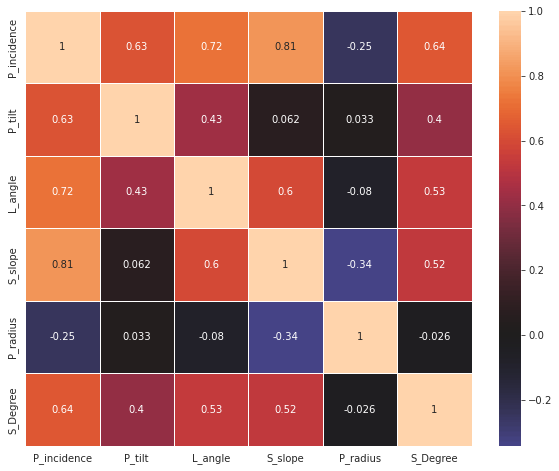

In [30]:
plt.figure(figsize=(10,8))
with sns.axes_style("white"):
    sns.heatmap(combine_df.corr(), annot=True,linewidths=.5, annot_kws={'size': 10}, center = 0)

### Sharing insights on correlation
- A. Features having stronger correlation with correlation value.
- B. Features having weaker correlation with correlation value.

#### A. Features having stronger correlation with correlation value.
- P_incidence has a stronger positive correlation with S_slope with a correlation value of 0.81

#### B. Features having weaker correlation with correlation value.
- P_radius has the weakest negative correlation with S_Degree with a correlation value of -0.026
- S_slope has the strongest negative  correlation with p_radius with a correlation value of -0.34

### Visualize a pairplot with 3 classes distinguished by colors and share insights

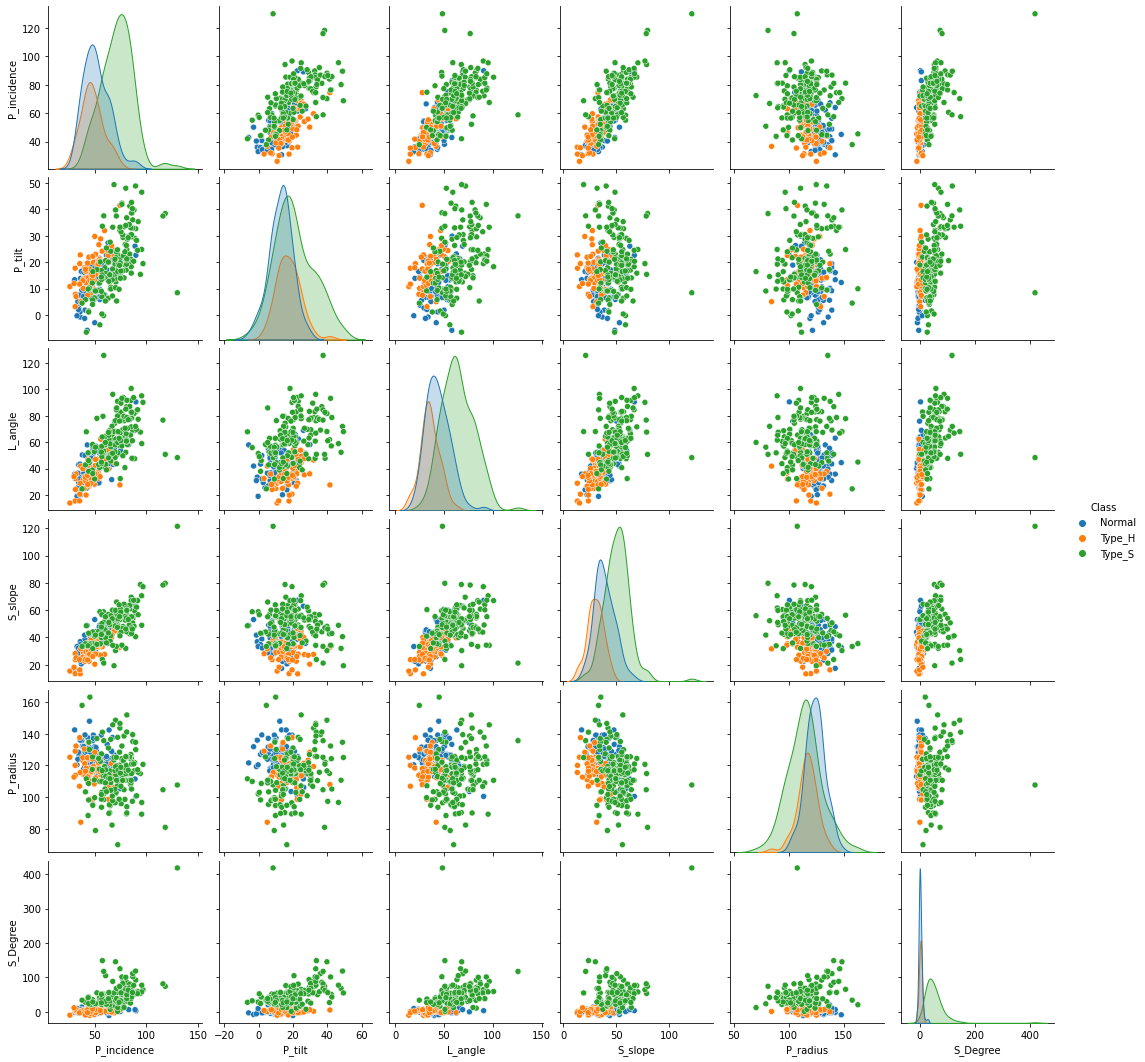

In [31]:
sns.pairplot(combine_df, hue = "Class")

**<span style="color:blue">Observations</span>**
- Based on density plots along the diagonals, we can see that
    - Except P_radius, all of the observations from the Type_S class have relatively higher mean and spread
- Based on the scatter plots for individual features,
    - Type_S class has larger number of observations, with large spread and a few outliers
    - Correlation of features can be corroborated with their correlation values as shown in heatmap of previous question
    - In 2D space, none of the features seem to clearly separates observations into clusters from different classes

### Visualize a jointplot for ‘P_incidence’ and ‘S_slope’ and share insights

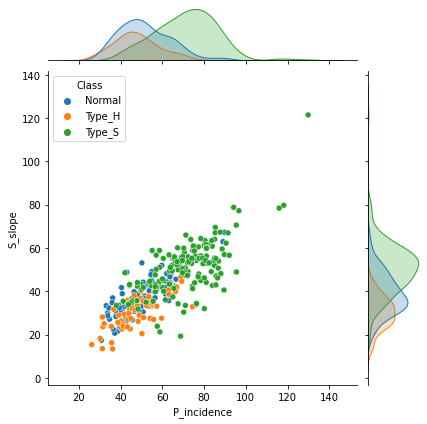

In [32]:
sns.jointplot (x = 'P_incidence', y = 'S_slope', data = combine_df, hue = "Class")

**<span style="color:blue">Observations</span>**
- Based on the scatterplot, P_incidence and S_slope are positively correlated, which was also observed in the heatmap of correlation values of the features.
- There are a few outliers belonging to the class Type_S with a very large value i.e. P_incidence > 100.
- Based on the density plot for S_slope, all three classes, have different mean and spread, with Type_S class having the higher mean and spread/variance.

### Visualize a boxplot to check distribution of the features and share insights

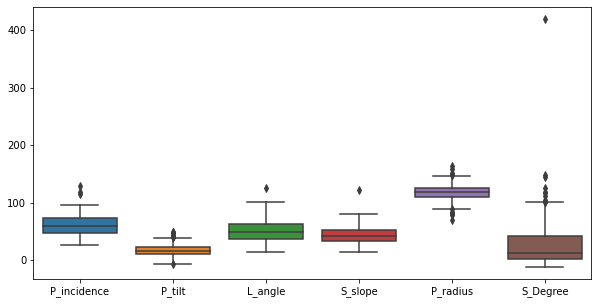

In [33]:
plt.figure(figsize=(10,5))
sns.boxplot(data=combine_df)
plt.show()

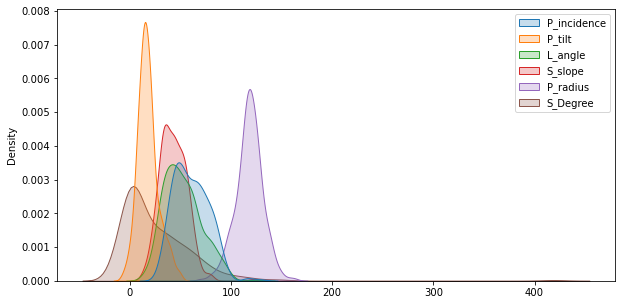

In [34]:
plt.figure(figsize=(10,5))
sns.kdeplot(data=combine_df, fill=True)
plt.show()

**<span style="color:blue">Observations</span>**
- Based on the boxplot and KDE distributions,
    - S_Degree has a skewed distribution with long tail on the right with a few outliers
    - P_tilt has a least variance
    - P_radius notable number of observations on both ends of the distributions beyond whiskers.

## Model Building

In [35]:
combine_df.groupby(['Class']).count()

,P_incidence,P_tilt,L_angle,S_slope,P_radius,S_Degree
Class,,,,,,
Normal,100,100,100,100,100,100
Type_H,60,60,60,60,60,60
Type_S,150,150,150,150,150,150


#### Split data into X and Y

In [36]:
X = combine_df.drop(labels= ["Class"] , axis = 1)
y = combine_df["Class"]
X.head()

,P_incidence,P_tilt,L_angle,S_slope,P_radius,S_Degree
0,38.505273,16.964297,35.112814,21.540976,127.632875,7.986683
1,54.920858,18.968430,51.601455,35.952428,125.846646,2.001642
2,44.362490,8.945435,46.902096,35.417055,129.220682,4.994195
3,48.318931,17.452121,48.000000,30.866809,128.980308,-0.910941
4,45.701789,10.659859,42.577846,35.041929,130.178314,-3.388910


In [37]:
XScaled  = X.apply(zscore)  # convert all attributes to Z scale 
XScaled.describe()

,P_incidence,P_tilt,L_angle,S_slope,P_radius,S_Degree
count,3.100000e+02,3.100000e+02,3.100000e+02,3.100000e+02,3.100000e+02,3.100000e+02
mean,1.042177e-16,2.096889e-16,1.980495e-16,2.829278e-17,-5.071212e-16,-1.277204e-16
std,1.001617e+00,1.001617e+00,1.001617e+00,1.001617e+00,1.001617e+00,1.001617e+00
min,-1.996010e+00,-2.411664e+00,-2.047652e+00,-2.207741e+00,-3.597963e+00,-9.961725e-01
25%,-8.173982e-01,-6.881138e-01,-8.060267e-01,-7.168418e-01,-5.423830e-01,-6.585073e-01
50%,-1.049246e-01,-1.186061e-01,-1.278621e-01,-4.095971e-02,2.613767e-02,-3.874502e-01
75%,7.194643e-01,4.581158e-01,5.975493e-01,7.269414e-01,5.676209e-01,3.997679e-01
max,4.029206e+00,3.191402e+00,3.984615e+00,5.855771e+00,3.395818e+00,1.046035e+01


#### Split data into train and test with 80:20 proportion

In [38]:
# Split X and y into training and test set in 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(XScaled, y, test_size=0.20, random_state=1)

In [39]:
print(X_train.shape)
print(y_train.shape)

(248, 6)
(248,)


In [40]:
print(X_test.shape)
print(y_test.shape)

(62, 6)
(62,)


### Train a Supervised Learning Classification base model using KNN classifier

In [41]:
#Build the model and train and test on training and test sets respectively using scikit-learn. Print the Accuracy of the model 
#with a default of k=5

In [42]:
# instantiate learning model (deafult k = 5)
knn = KNeighborsClassifier()

# fitting the model
knn.fit(X_train, y_train)

# predict the response
y_pred = knn.predict(X_test)

# evaluate accuracy
print(round(accuracy_score(y_test, y_pred), 2))

0.73


### Print all the possible performance metrics for both train and test data


Confusion Matrix


<AxesSubplot:>

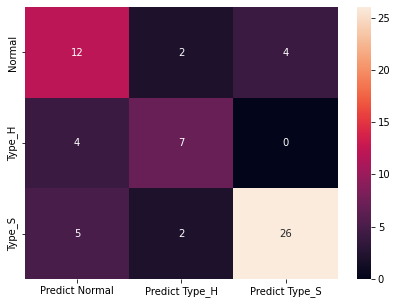

In [43]:
# calculate accuracy measures and confusion matrix
from sklearn import metrics
print("Confusion Matrix")
cm=metrics.confusion_matrix(y_test, y_pred, labels=["Normal", "Type_H","Type_S"])
df_cm = pd.DataFrame(cm, index = [i for i in ["Normal","Type_H","Type_S"]],
                  columns = [i for i in ["Predict Normal","Predict Type_H", "Predict Type_S"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True)

In [44]:
cm=metrics.classification_report(y_test, y_pred, labels=["Normal", "Type_H","Type_S"])
print(cm)

              precision    recall  f1-score   support

      Normal       0.57      0.67      0.62        18
      Type_H       0.64      0.64      0.64        11
      Type_S       0.87      0.79      0.83        33

    accuracy                           0.73        62
   macro avg       0.69      0.70      0.69        62
weighted avg       0.74      0.73      0.73        62



In [45]:
y_train.value_counts()

Type_S    117
Normal     82
Type_H     49
Name: Class, dtype: int64

**Observation**
- Type_S shows higher precision, recall, f1-score and support compared to Type_H and Normal.
- We have more observations to train for Type_S (i.e 117) compared to other 2 classes that could be a possible reason for better model performance

## Performance Improvement

### Experiment with various parameters to improve performance of the base model

**Major parameter of KNN classifier:**
- K : Number of neighbors
- Distance measure
- Weights
- P: Power parameter for Minkowski metric

In [46]:
# Define parameters for model assessment
params = {
    'n_neighbors': [ i for i in np.arange(3, 30, 1) if i%2 != 0],
    'weights': ['uniform', 'distance'],
    'p': [1,2]
}

In [47]:
knn = KNeighborsClassifier()

In [48]:
# Model score with default parameters
knn.fit(X_train, y_train)
defaultScore = knn.score(X_test, y_test)
print(defaultScore)

0.7258064516129032


In [49]:
#Build KNN model with various parameter values and store the corresponsing scores for comparison
knn_neighbors = []
knn_weights = []
knn_power = []
knn_score_train = []
knn_score_test = []

for neighbors in params['n_neighbors']:
    for weight in params['weights']:
        for power in params['p']:
            knn = KNeighborsClassifier(n_neighbors= neighbors , weights = weight, p=power)
            knn_neighbors.append(neighbors)
            knn_weights.append(weight)
            knn_power.append(power)
            knn.fit(X_train, y_train)
            knn_score_train.append(knn.score(X_train, y_train))
            knn_score_test.append(knn.score(X_test, y_test))

In [50]:
#Storing all the parameters and their scores in pandas dataframe
knn_performance_summary = pd.DataFrame({
    'Neighbors': knn_neighbors,
    'Weights' : knn_weights,
    'Power' : knn_power,
    'KNN-Train_Score': knn_score_train,
    'KNN-Test_Score': knn_score_test,
})

In [51]:
knn_performance_summary['DefaultScore'] = defaultScore

**Calculation of %score improvement compared to default score**

%Change = [ (new score - old score) / old score ] * 100

In [52]:
knn_performance_summary['%Score_change'] = [round(((new - old)/old)*100,2) for new, old in zip(knn_performance_summary['KNN-Test_Score'], knn_performance_summary['DefaultScore'])]

**Show top models and their parameters based on model score on test data**

In [53]:
knn_performance_summary.sort_values(by=['KNN-Test_Score', 'Neighbors'], ascending=False).head()

,Neighbors,Weights,Power,KNN-Train_Score,KNN-Test_Score,DefaultScore,%Score_change
36,21,uniform,1,0.822581,0.790323,0.725806,8.89
40,23,uniform,1,0.814516,0.774194,0.725806,6.67
32,19,uniform,1,0.814516,0.774194,0.725806,6.67
18,11,distance,1,1.000000,0.774194,0.725806,6.67
10,7,distance,1,1.000000,0.774194,0.725806,6.67


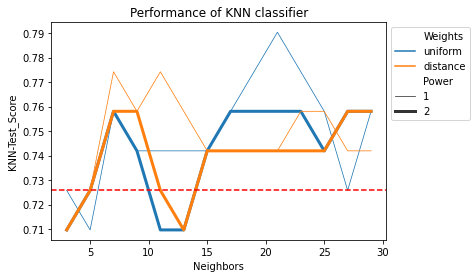

In [54]:
#Visualize performance of the model w.r.t their number of neighbours, weights and power 
sns.lineplot(data=knn_performance_summary, x = 'Neighbors', y = 'KNN-Test_Score', size='Power', hue = 'Weights')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.axhline(y=defaultScore, c = 'red', linestyle='--')
plt.title("Performance of KNN classifier");

**Note:**
 Dashed red line shows test accuracy score of base model

**<span style="color:blue">Observations</span>**
- From the above results, it can be observed that,
    - A model with **21 neighbors** and **uniform weights with power 1** gives highest test accuracy score of **79.03%**
        - It offers **8.89% improvement** in score over base model
        - This model uses a higher number of neighbors i.e. K = 21, so might be little computationally intensive
    - All the remainig top models show test accuracy score of **77.42%**, 
        - These models offer **6.67% improvement** in score over base model
        - Among them a model with with **7 neighbors** and **distance-based weights with power 1** would be a better choice
        - because with low number of neighbors it will be computationally less intensive offering same score for classification


### Print all the possible performance metrics for both train and test data

Confusion Matrices


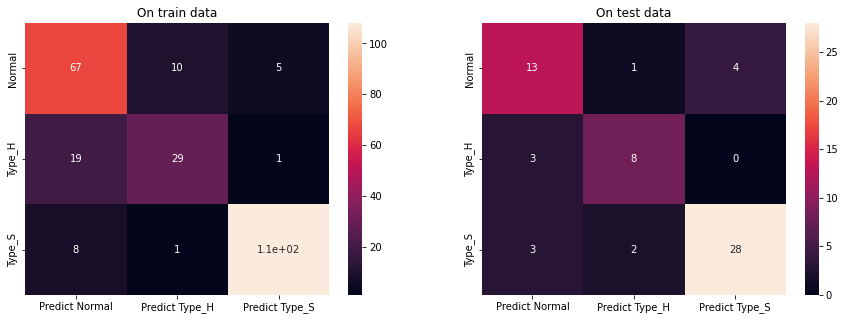

In [55]:
# calculate accuracy measures and confusion matrix
from sklearn import metrics

knn = KNeighborsClassifier(n_neighbors= 21 , weights = 'uniform', p=1)
knn.fit(X_train, y_train)

#Prediction on the trainset data
y_train_pred = knn.predict(X_train) 

#Prediction on the testset data 
y_pred = knn.predict(X_test) 


print("Confusion Matrices")
cm_train=metrics.confusion_matrix(y_train, y_train_pred, labels=["Normal", "Type_H","Type_S"])
df_cm_train = pd.DataFrame(cm_train, index = [i for i in ["Normal","Type_H","Type_S"]],
                  columns = [i for i in ["Predict Normal","Predict Type_H", "Predict Type_S"]])

cm_test=metrics.confusion_matrix(y_test, y_pred, labels=["Normal", "Type_H","Type_S"])
df_cm_test = pd.DataFrame(cm_test, index = [i for i in ["Normal","Type_H","Type_S"]],
                  columns = [i for i in ["Predict Normal","Predict Type_H", "Predict Type_S"]])


#plt.figure(figsize = (15,5))
fig, axes = plt.subplots(1, 2, figsize = (15,5))
sns.heatmap(df_cm_train, annot=True, ax=axes[0])
sns.heatmap(df_cm_test, annot=True, ax=axes[1])
axes[0].set_title("On train data")
axes[1].set_title("On test data")
plt.show();

**Classification report on Training data set**

In [56]:
# Classification Report on Training Data set
cm=metrics.classification_report(y_train, y_train_pred, labels=["Normal", "Type_H","Type_S"])
print(cm)

              precision    recall  f1-score   support

      Normal       0.71      0.82      0.76        82
      Type_H       0.72      0.59      0.65        49
      Type_S       0.95      0.92      0.94       117

    accuracy                           0.82       248
   macro avg       0.80      0.78      0.78       248
weighted avg       0.83      0.82      0.82       248



**Classification report on Test data set**

In [57]:
#Classification Report on Test Data set
cm=metrics.classification_report(y_test, y_pred, labels=["Normal", "Type_H","Type_S"])
print(cm)

              precision    recall  f1-score   support

      Normal       0.68      0.72      0.70        18
      Type_H       0.73      0.73      0.73        11
      Type_S       0.88      0.85      0.86        33

    accuracy                           0.79        62
   macro avg       0.76      0.77      0.76        62
weighted avg       0.79      0.79      0.79        62



### Parameters contributed most to improve model performance

In [58]:
knn_performance_summary.sort_values(by=['KNN-Test_Score', 'Neighbors'], ascending=False).head()

,Neighbors,Weights,Power,KNN-Train_Score,KNN-Test_Score,DefaultScore,%Score_change
36,21,uniform,1,0.822581,0.790323,0.725806,8.89
40,23,uniform,1,0.814516,0.774194,0.725806,6.67
32,19,uniform,1,0.814516,0.774194,0.725806,6.67
18,11,distance,1,1.000000,0.774194,0.725806,6.67
10,7,distance,1,1.000000,0.774194,0.725806,6.67


**As can be seen from the above table, the Number of neighbors followed by Weights contributed most to improve model performance**